## Visualizing Filters of a Convolutional Neural Network

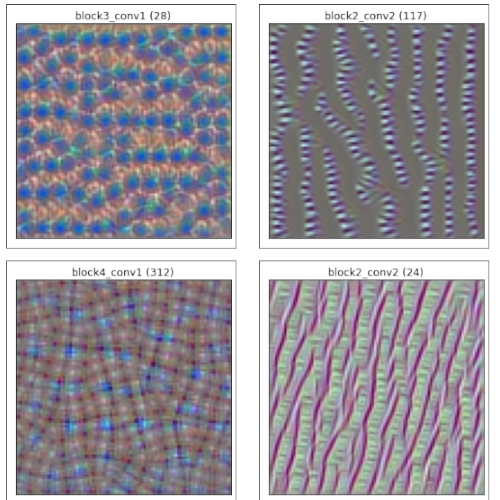

## Task 2: Downloading the Model

In [1]:
#Se quieren visualizar los filtros para entender qué busca cada filtro
#en el input y así se puede entender mejor las redes neuronales conv.
import tensorflow as tf
import random
import matplotlib.pyplot as plt

print('TensorFlow version', tf.__version__)

TensorFlow version 2.8.0


In [2]:
#Se usa la CNN llamada VGG16, una muy popular.
model = tf.keras.applications.vgg16.VGG16(
    include_top=False,  #significa que las últimas fully connected
                        #layers de la CNN no van a estar incluídas en este modelo, no
                        #las necesitamos porque no estamos haciendo una clasificación.
    weights='imagenet', #Se bajan los weights ya entrenados con el imagenet dataset.
    input_shape=(96,96,3)
)

model.summary()
#En las primeras capas convolusionales se aprenden muchas features muy sencillas,
#conforme se avanza a las del bloque 4 o 5 las features se vuelven más complejas
#y los patrones más complicados.

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

## Task 3: Get Layer Output

In [3]:
#Se usan submodelos para ver los input/output de un layer específico
def get_submodel(layer_name):
  return tf.keras.models.Model(
      model.input,
      model.get_layer(layer_name).output
  )

get_submodel('block1_conv2').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


## Task 4: Image Visualization

In [4]:
#La idea del proyecto es entender qué es lo que está buscando un filtro
#de una capa particular en el input. Se quiere optimizar la imagen de input
#de manera que esta gradualmente se vaya moviendo hacia el mostrar la feature
#específica con la cual ese filtro se vea max activado.

def create_image():
  return tf.random.uniform((96,96,3), minval=-0.5, maxval=0.5)

def plot_image(image, title='random'):
  image = image - tf.math.reduce_min(image) #Para tener todos los valores positivos
  image = image / tf.math.reduce_max(image) #Para que todos los valores estén entre 0 y 1
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()

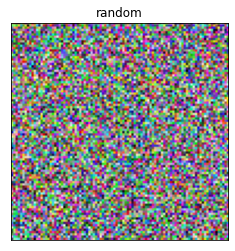

In [5]:
image = create_image()
plot_image(image)

## Task 5: Training Loop

In [6]:
#Muestra el input que maximiza la activación de un filtro específico,
#o sea, muestra qué es lo que ese filtro busca en las input images.
def visualize_filter(layer_name, f_index=None, iters=50):
  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1]

  if f_index is None:
    f_index = random.randint(0, num_filters - 1)
  assert num_filters > f_index, 'f_index is out of range'

  image = create_image()
  verbose_step = int(iters / 10)

  #Gradient ascent: se quiere maximizar la loss value
  for i in range(0, iters):
    with tf.GradientTape() as tape:
      tape.watch(image)   #Keep track of the image, se ven todas las 
                          #operaciones que se le realicen a la input image
      out = submodel(tf.expand_dims(image, axis=0))[:,:,:,f_index]  #Se expanden las
                          #dimensiones porque el modelo espera el batchsize, que 
                          #sería 1 en este caso
      loss = tf.math.reduce_mean(out)   #Lo que se quiere maximizar
    grads = tape.gradient(loss, image)  #Calcula los gradientes 
    grads = tf.math.l2_normalize(grads) #Se normaliza para que los gradientes
                                        #no se vuelvan locos en ninguna dirección
    image += grads *10    #Update the image, los gradientes pueden ser pequeños,
                          #entonces se puede usar un lr mayor para acelerar el proceso
    
    #Keep track of the loss
    if (i + 1) % verbose_step == 0:
      print(f'Iteration: {i + 1}, Loss: {loss.numpy():.4f}')

  plot_image(image, f'{layer_name}, {f_index}')


## Task 6: Final Results

In [7]:
print([layer.name for layer in model.layers if 'conv' in layer.name])

['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']


Iteration: 10, Loss: 22.7331
Iteration: 20, Loss: 43.9990
Iteration: 30, Loss: 66.6236
Iteration: 40, Loss: 92.1930
Iteration: 50, Loss: 122.8479
Iteration: 60, Loss: 157.3312
Iteration: 70, Loss: 195.4418
Iteration: 80, Loss: 236.7650
Iteration: 90, Loss: 279.7256
Iteration: 100, Loss: 323.5340


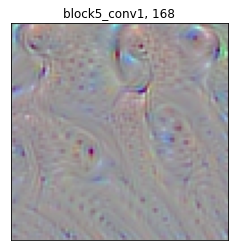

In [8]:
layer_name = 'block5_conv1' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, iters=100)

In [8]:
#Dead filters: el loss no cambia, no sirven, pueden eliminarse de la red
#ya que no tienen una función significativa. El gradiente no encuentra
#un máximo para este filtro y depende de la input image.